In [1]:
# check virtual environment path
import sys
print(sys.version)
print(*sys.path, sep='\n')

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload

/home/lukec/venv/lib/python3.6/site-packages
/home/lukec/.local/lib/python3.6/site-packages
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/home/lukec/venv/lib/python3.6/site-packages/IPython/extensions
/home/lukec/.ipython


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision as tv
import foolbox
from foolbox.models import PyTorchModel

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

num_workers = os.cpu_count()
print(num_workers)

cuda:0
6


In [4]:
# parameters for trained CNN
root = os.path.join('.', 'dataset_root')
mean, std = [0.13066046], [0.30150425] # based on training set
batch_size = 64
lr = 0.01
momentum=0.9
step_size=10
gamma=0.1
epochs = 20
model_path = 'mnist_cnn.pt'

In [5]:
def imshow(tensor_grid, mean=0., std=1., title=None):
    assert isinstance(tensor_grid, torch.Tensor)
    assert len(tensor_grid.size()) == 4, \
        f'For a batch of images only, {tensor_grid.size()} '
    
    tensor_grid = tv.utils.make_grid(tensor_grid)
    grid = tensor_grid.numpy().transpose((1,2,0))
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)

In [6]:
# prepare data
# foolbox model expects raw numpy array as image
transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(mean, std)])
train_dataset = tv.datasets.MNIST(
    root,
    train=True, 
    download=True,
    transform=transform)
test_dataset = tv.datasets.MNIST(
    root,
    train=False, 
    download=True,
    transform=transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

In [7]:
# CNN
# https://foolbox.readthedocs.io/en/stable/modules/models.html#foolbox.models.PyTorchModel
# "It should predict logits or log-probabilities, i.e. predictions without the softmax."
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        # remove the softmax layer
        x = F.log_softmax(x, dim=1)  # caveat log(softmax(x))
        return x

In [8]:
# load parameters
model = Net()
model.load_state_dict(torch.load(model_path))
model.eval()
model = model.to(device)

In [9]:
def validate(loader):
    model.eval()
    total_loss = 0.
    corrects = 0
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            batch_size = x.size(0)
            output = model(x)
            loss = F.nll_loss(output, y).item()
            total_loss += loss * batch_size
            preds = output.max(1, keepdim=True)[1]
            corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [10]:
print(len(test_loader.dataset))
va_loss, va_acc = validate(test_loader)
print('Test Loss: {:.4f} Accuracy: {:.4f}%'.format(va_loss, va_acc*100.))

10000
Test Loss: 0.0275 Accuracy: 99.1000%


In [11]:
model.eval()
with torch.no_grad():
    x, y = next(iter(test_loader))
    x = x.to(device)
    y = y.to(device)
    output = model(x)
    print(output.size())
    for i in output[:1].cpu().detach().numpy():
        print(i)

torch.Size([64, 10])
[-39.88433  -29.848688 -31.630215   0.       -43.97391  -27.909836
 -45.130424 -27.633076 -33.567783 -25.577095]


In [12]:
preprocessing = {'mean': mean, 'std': std, 'axis': -1}  # for single channel
fmodel = PyTorchModel(
    model, 
    bounds=(0, 1), 
    num_classes=10, 
    preprocessing=preprocessing,
    channel_axis=1,
    device=device)

In [13]:
# a image loader without transform
test_raw_dataset = tv.datasets.MNIST(
    root,
    train=False, 
    download=True,
    transform=tv.transforms.Compose([
        tv.transforms.ToTensor()]))

test_raw_loader = DataLoader(
    test_raw_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

In [26]:
# caveat: foolbox model is looking for raw image!
with torch.no_grad():
    x, y = next(iter(test_raw_loader))
    np_x = x.numpy()
    np_y = y.numpy()
    print(np_x.shape, np_y.shape)
    print(np_x.dtype)
    
    output = fmodel.forward(np_x)
    print(*(output[0]), sep=' ')
    pred = output.argmax(axis=-1)
    print(output.shape)
    accuracy = np.mean(pred == np_y)
    print(accuracy)

(64, 1, 28, 28) (64,)
float32
-26.120022 -16.450493 0.0 -22.969269 -38.365513 -39.74011 -33.229435 -17.982346 -28.115908 -37.43552
(64, 10)
0.96875


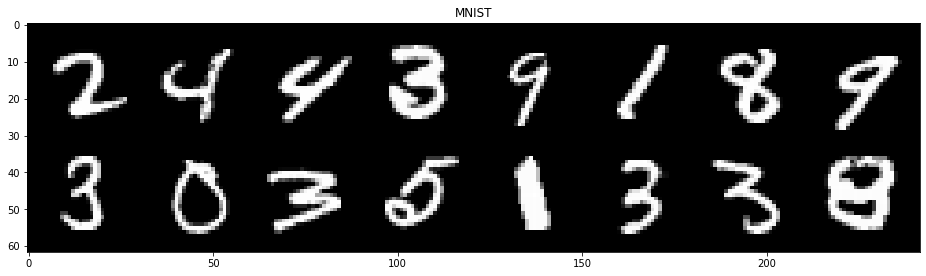

In [27]:
plt.figure(figsize=[16,8])
imshow(x[:16], title='MNIST')
plt.show()

In [48]:
attack = foolbox.attacks.BIM(
    fmodel,
    criterion=foolbox.criteria.Misclassification(),
    distance=foolbox.distances.Linfinity,
    threshold=0.15
)
adversarials = attack(np_x, np_y)
output = fmodel.forward(adversarials)
print('output', output.shape)
pred = output.argmax(axis=1)
print('pred', pred.shape)
print('adversarials', adversarials.shape)
print(np.mean(pred == np_y))

output (64, 10)
pred (64,)
adversarials (64, 1, 28, 28)
0.0


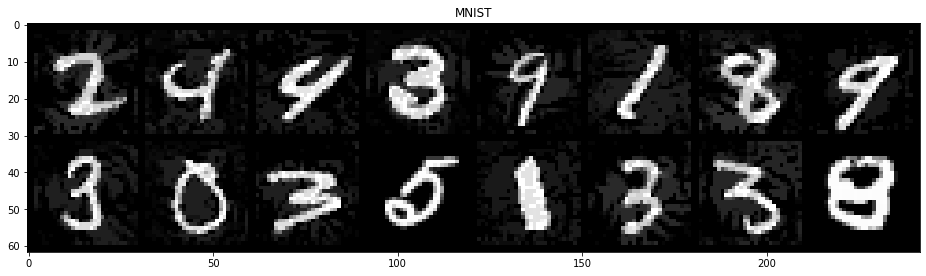

[1 9 9 8 7 2 3 4 9 8 7 0 8 7 5 9]
[2 4 4 3 9 1 8 9 3 0 3 5 1 3 3 8]


In [49]:
img_tensor = torch.tensor(adversarials[:16])
plt.figure(figsize=[16,8])
imshow(img_tensor, title='MNIST')
plt.show()

print(pred[:16])
print(np_y[:16])